# Analysis of human and model behavior across physical domains

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Visualize distribution and compute summary statistics over **model** physical judgments
* Conduct human-model comparisons
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [73]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [74]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [75]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### experiment metadata

In [76]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [77]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

### generate summary table of human 95% CIs for accuracy across all scenarios

In [137]:
## init bootAcc for plotting
bootAcc = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]
    scenarioName = _D.scenarioName.values[0]
    
    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)

    ## compute bootstrapped sampling distributions of accuracy
    Dacc = D.groupby('prolificIDAnon').agg({'correct':np.mean})
    bootmeans = bootstrap_mean(Dacc, col='correct', nIter=1000)

    obsmean = np.mean(Dacc.correct.values)
    bootmean = np.mean(bootmeans)
    lb = np.percentile(bootmeans,2.5)
    ub = np.percentile(bootmeans,97.5)
    
    ## merge bootstrapped accuracy estimates
    if len(bootAcc)==0:
        bootAcc = pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub]).transpose()
    else:
        bootAcc = pd.concat([bootAcc, pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub]).transpose()],axis=0)
        
## add column names        
bootAcc.columns=['agent','scenario','obs_mean', 'boot_mean', '95ci_lb', '95ci_ub']

## save out bootAcc to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))
bootAcc.to_csv(os.path.join(csv_dir, 'summary','human_accuracy_by_scenario.csv'), index=False)

Currently analyzing the collision experiment.
Currently analyzing the rollingsliding experiment.
Currently analyzing the dominoes experiment.
Currently analyzing the drop experiment.
Currently analyzing the clothiness experiment.
Currently analyzing the linking experiment.
Currently analyzing the containment experiment.
Currently analyzing the towers experiment.


In [130]:
bootAcc

,agent,scenario,obs_mean,boot_mean,95ci_lb,95ci_ub
0,human,towers,0.808511,0.808485,0.798793,0.81766
0,human,collision,0.882986,0.882948,0.875411,0.890696
0,human,rollingsliding,0.692791,0.6927,0.684341,0.701163
0,human,dominoes,0.743656,0.743722,0.73541,0.751326
0,human,drop,0.678133,0.678222,0.663729,0.692269
0,human,clothiness,0.643182,0.643234,0.631968,0.654545
0,human,linking,0.766988,0.766892,0.758072,0.775026
0,human,containment,0.763137,0.763012,0.754975,0.770982


### Human accuracy across stimuli for each participant
We will analyze accuracy for each participant by computing the proportion of correct responses across all stimuli. 



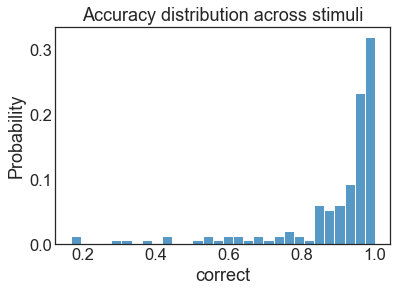

In [34]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
p = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

### Human-human consistency for each stimulus
We will estimate human-human consistency for each stimulus by computing the proportion of responses that match the modal response for that stimulus (whether that modal response is correct or incorrect).



In [35]:
assert len(np.unique(D.groupby('stim_ID').agg({'correct':'count'})['correct'].values))==1 # sanity check
numSubs = np.unique(D.groupby('stim_ID').agg({'correct':'count'})['correct'].values)[0] # get num subs
Dmode = D.groupby('stim_ID').agg({'responseBool':scipy.stats.mode}) # compute modal response
propModalResponse = Dmode['responseBool'].apply(lambda x: x[1][0]).values / numSubs # get proportion modal response
Dmode = Dmode.assign(propModalResponse = Dmode['responseBool'].apply(lambda x: x[1][0]).values / numSubs) 
Dcombined = Dacc.merge(Dmode, left_index=True, right_index=True)

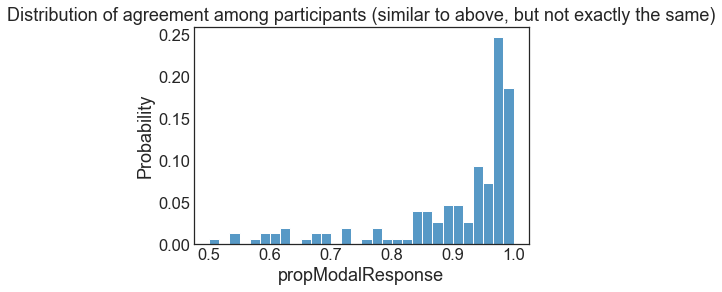

In [36]:
p = sns.histplot(data=Dmode, x='propModalResponse', bins=30, stat='probability')
t = plt.title('Distribution of agreement among participants (similar to above, but not exactly the same)')

### Human-human consistency across stimuli (within scenario)
We will analyze human-human consistency by computing the mean correlation between (binary) response vectors produced by each human participant across all stimuli within each scenario. 



In [37]:
## create response feature matrix (numSubs x numTrialsPerSub)
D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
numSubs = len(np.unique(D['prolificIDAnon'].values))
numTrialsPerSub = int(len(D)/numSubs)
respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

## sanity check that the reshape operation happened correctly
assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0

In [54]:
## get pairwise correlation distances
dists = scipy.spatial.distance.pdist(respMat, metric='correlation')
corrMat = scipy.spatial.distance.squareform(dists)

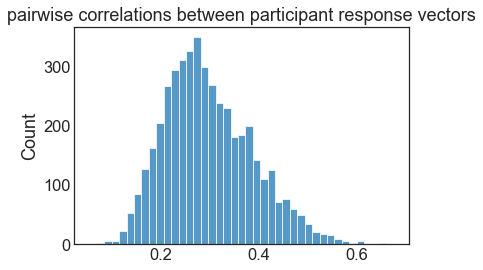

In [55]:
## distribution of pairwise correlations between participant response vectors
p = sns.histplot(corrMat[np.triu_indices(n=len(corrMat), k=1)])
t = plt.title('pairwise correlations between participant response vectors')

In [56]:
pairwiseCorrs = corrMat[np.triu_indices(n=len(corrMat), k=1)]
lb = np.percentile(pairwiseCorrs, 2.5)
ub = np.percentile(pairwiseCorrs, 97.5)
print('The median pairwise correlation is {}.'.format(np.percentile(pairwiseCorrs, 50).round(3)))
print('95% CI: [{},{}].'.format(lb.round(3),ub.round(3)))

The median pairwise correlation is 0.286.
95% CI: [0.149,0.494].


In [57]:
## plot heatmap of correlation distances between participants
reallyRun = False
if reallyRun:
    sns.heatmap(corrMat, square=True)

### Human accuracy as a function of stimulus attributes
We will conduct exploratory analyses of human accuracy as a function of various scenario-specific stimulus attributes that varied across trials. We will examine those stimulus attributes that varied across stimuli within each scenario and explore the relationship between each individual attribute and human accuracy, as well as beetween linear combinations of them and human accuracy. 



In [ ]:
## TODO

### Human accuracy by scenario
We will fit human responses across all scenarios with a mixed-effects logistic regression model, including scenario as a fixed effect and participants and individual stimuli as random effects.



### Other exploratory human behavioral analyses
* We will explore the relation of demographic variables on the performance of participants: how does age, gender, educational status and the the result of a one-trial spatial reasoning task relate to the overall accuracy of a subject?
* We will additionally explore any potential left/right or yes/no response biases. 


## Visualize distribution of model physical judgments, by domain

## Compute summary statistics over model physical judgments, by domain

## Conduct human-model comparisons
We will compare human and model behavior in two ways: **absolute performance** and **response pattern.**

#### **Absolute Performance** 
We will compare the accuracy of each model to the mean accuracy of humans, for each scenario. 
To do this, we will first compute estimates of mean human accuracy for each scenario and construct 95% confidence intervals for each of these estimates. 
These confidence intervals will be constructed by bootstrapping: specifically, for an experiment with N participants, we will resample N participants with replacement and compute the proportion correct for that bootstrapped sample. We will take repeat this resampling procedure 1000 times to generate a sampling distribution for the mean proportion correct. The 2.5th and 97.5th percentile will be extracted from this sampling distribution to provide the lower and upper bounds of the 95% confidence interval.

For each model, we will then compare their proportion correct (a point estimate) to the human confidence interval. 

#### **Response Pattern**
We will compare the pattern of predictions generated by each model to the pattern of predictions generated by humans. 

We will do this by using two standard inter-rater reliability metrics:
##### **Correlation**
For each pair of human participants, we will compute the correlation between their (binary) response vectors, yielding a distribution of pairwise human-human correlations. 
For each model, we will compute the correlation between its response vector and every human participant, as well as every other model. 
A model's response pattern will be considered more similar to humans' insofar as the mean model-human correlation (across humans) lies closer to the mean human-human correlation (for all pairs of humans).

##### **Cohen's kappa**